In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import lyricsgenius as genius
from bs4 import BeautifulSoup

from nltk.tokenize import word_tokenize
from nltk.parse.corenlp import CoreNLPParser
from nltk.corpus import words

import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout,Flatten
from keras.layers import LSTM,Bidirectional,Embedding, Input,SpatialDropout1D
from keras.optimizers import RMSprop
from keras.models import Model,load_model
from keras.callbacks import LambdaCallback, ModelCheckpoint,EarlyStopping
from keras.utils import to_categorical

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split,ShuffleSplit,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score,recall_score,auc,f1_score,classification_report

from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix

import math
import re
import string
import requests
from collections import Counter
import random
import sys
import io

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

from io import BytesIO
import zipfile
from zipfile import ZipFile
from urllib.request import urlopen

plt.style.use("ggplot")
%matplotlib inline 

## Gathering Scripts

In [ ]:
api = genius.Genius('API_Key')
Game_Of_Thrones = api.search_artist('Game of Thrones', max_songs=100)
Game_Of_Thrones.save_lyrics()#Saving Lyrics

## Some Exploratory Data Analysis of the script

In [2]:
json_file = pd.read_json("Lyrics_GameofThrones.json")#reading in file

In [3]:
values = list(json_file.songs.values)#converting lyrics to dataframe
converted = pd.DataFrame(values)

/anaconda/lib/python3.6/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


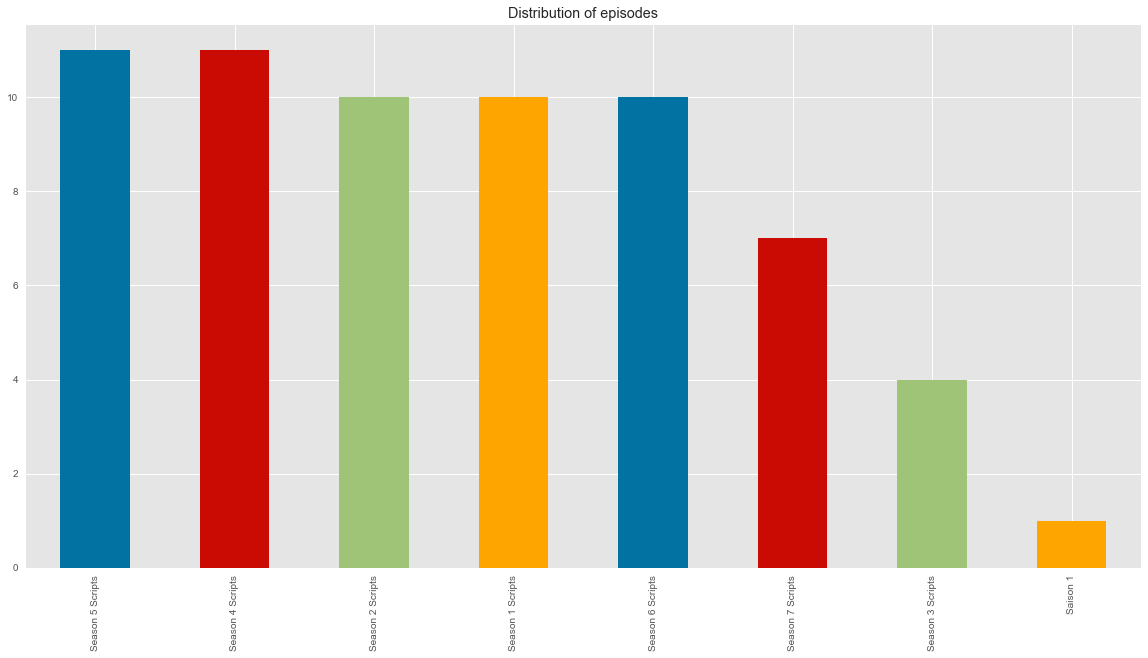

In [4]:
#visualizing which seasons have complete/incomplete data
plt.figure(figsize = (20,10))
season_counts = (converted.album.value_counts())
season_counts.plot(kind = "bar",colors = ["b","r","g","orange"],title = "Distribution of episodes")

In [5]:
converted=converted[converted.album!="Saison 1"]
(converted.album.value_counts())

Season 5 Scripts    11
Season 4 Scripts    11
Season 2 Scripts    10
Season 1 Scripts    10
Season 6 Scripts    10
Season 7 Scripts     7
Season 3 Scripts     4
Name: album, dtype: int64

# Uploading Pre-Trained Embeddings

In [13]:
name_of_file = "glove.6B.200d.txt.word2vec"

In [14]:
# Load embeddings into notebook
glove = KeyedVectors.load_word2vec_format(name_of_file, binary=False)

## Preprocessing Texts

In [15]:
strings=re.sub(":","",string.punctuation) #removing semi-colons from punctuation

In [16]:
converted["clean_lyrics"]=converted.lyrics.apply(func=lambda x: x.translate(str.maketrans('', '', strings)))
#removing punctuation from scripts

In [17]:
def sub_out(x):
    """Separating colons from words"""
    su=re.sub("\n",'\n'*2,x)

    character_line=" ".join(re.findall('(.*?:.*)',su))
    
    return character_line
converted["tokenized"]=converted.clean_lyrics.apply(func= lambda x: sub_out(x))

In [18]:
full_text=(" ".join(converted["tokenized"].values)).lower()
#joining text

In [19]:
len(full_text.split(" "))

267897

In [20]:
full_text=re.sub("\s(\s)","",full_text)#subbing out \s
#removing \n from text
text_in_words = [w for w in full_text.split(' ') if w.strip() != '' or w == '\n' ]

#this for-loop separates ":" from words so that "Tyrion:" would become 'Tyrion' ":"
text_in_word = []
for word_ in text_in_words: 
    if len(re.split(":",word_)) > 1:
        split=re.split(":",word_)
        split.insert(1,":")
        for w in split:
            if len(w) <1:
                "next"
            else:
                text_in_word.append(w)
            
    else:
        text_in_word.append(word_)

## After some inspection I discovered that the text had quite a bit of mispelled words - so I removed words that were not coherent English or had not appeared 15 times (i.e. character names)

In [21]:
unique_words = set(text_in_word)
word_counts = Counter(text_in_word)#count of each words
english_words = words.words() #NLTK list of English words
min_number = 12

In [22]:
print("Count of unique words : %d" % len(word_counts))

Count of unique words : 11487


In [23]:
def roundup(x):
    return int(math.ceil(x / 50)) * 50

In [24]:
#rounding values to nearest 50
rounded_values = [roundup(value) for b,value in word_counts.items()]

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


[Text(0, 0.5, 'Number of words'),
 Text(0.5, 0, 'Number of appearences'),
 Text(0.5, 1.0, 'Distribution of word appearance')]

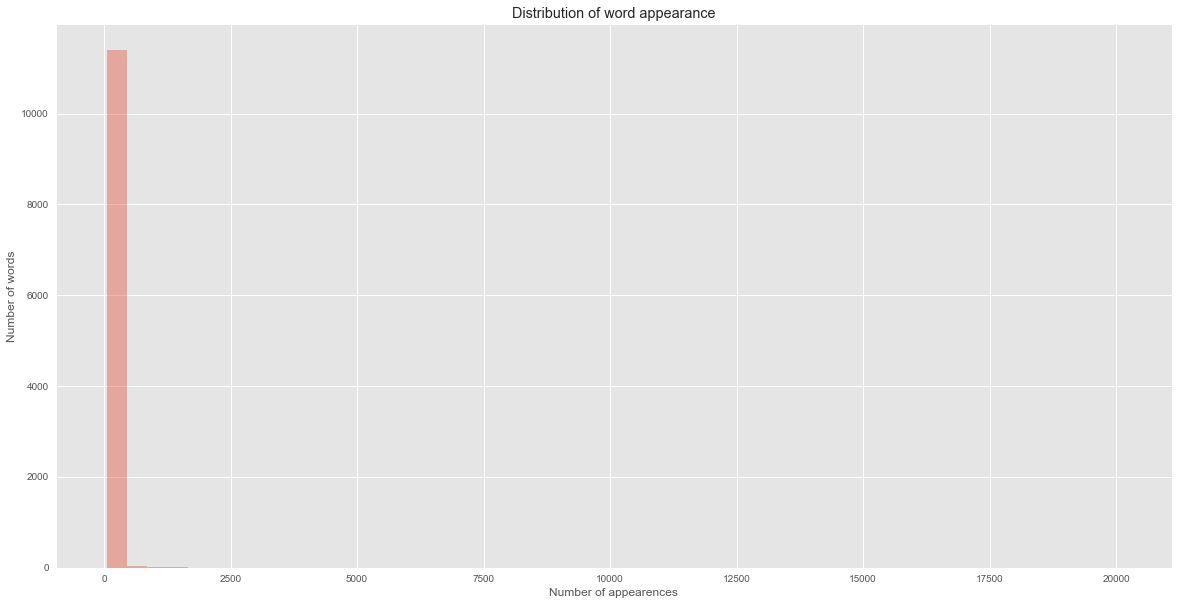

In [25]:
#Plotting distribution of word appearances
plt.figure(figsize=(20,10))
ax = sns.distplot(rounded_values,kde=False)
ax.set(xlabel='Number of appearences', ylabel='Number of words',title="Distribution of word appearance")

In [26]:
real_english = [word for word in word_counts.keys() if word in english_words] #which words are real?
not_real = set(unique_words)-set(real_english) #what words are not real? According to NLTK
new_text = [word for word in text_in_word if word not in not_real or word_counts[word] >= min_number]

In [27]:
new_text = re.sub("\…|\’|\”|\“|\‘",""," ".join(new_text)) #sub out these values

In [28]:
#what words are not in the pretrained Word Embeddings?
i=0
words_not_in_model=[]
for word in new_text.split(" "):
    try:
        mode=glove[word]
        i+=1
    except KeyError: 
        try:
           
            mode=glove[word.title()]
            i+=1
        except:
            try:
                word=lemmatizer.lemmatize(word)
                mode=glove[word]
                i+=1
            except:
                words_not_in_model.append(word) #append word

In [29]:
unique_words = set(words_not_in_model)#unique words not present

### Due to the fact that some names are not in pre-trained embeddings, the training set for becomes slightly smaller to make both consistent

In [30]:
training_text = [word for word in new_text.split(" ") if word not in unique_words]
#new training set

In [31]:
all_words = sorted(list(set(training_text)))#list of all words
all_char_num=dict((char, num) for num, char in enumerate(all_words)) #word index
all_num_char=dict((num, char) for num, char in enumerate(all_words))#number to word index

In [32]:
#Creating sequences
max_len= 25
sequence=[]
n_char = []
next_=[]
for num in range(0, len(training_text) - max_len):
    sequence.append((training_text)[num: num + max_len])
    n_char.append((training_text)[num + max_len])
print('Number of sequences:', len(sequence))
print()


Number of sequences: 263731



In [33]:
train_size=int(np.round(len(sequence)*.8,0))#training set 
test_size=int(train_size+(.05*len(sequence)))#test Set

## Essential Functions for both LSTMS

In [34]:
def sample(preds, temperature=1.0):
    """Function Taken From https://github.com/llSourcell/keras_explained/blob/master/gentext.py"""
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [35]:
def on_epoch_end(epoch, _):
    """Function modeled From"https://github.com/llSourcell/keras_explained/blob/master/gentext.py"""
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(training_text) - max_len - 1)
    for diversity in [0.2,.5,.8,1.2,1.5,1.8 ]:
        print('----- diversity:', diversity)

        generated = ""
        sequence_ = training_text[start_index: start_index + max_len]
        sequence=" ".join(sequence_)
        
        generated += sequence
        print('----- Generating with seed: "' + sequence + '"')
        sys.stdout.write(generated)

        for i in range(200):
            x_pred = np.zeros((1, max_len, len(all_words)))
            for b, char in enumerate(sequence_):
                x_pred[0, b, all_char_num[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = all_num_char[next_index]

            generated += " "+next_char
            
            sequence=sequence[1:]+ " "+ next_char
            
    
        print(generated)
        print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)


In [36]:
def generate_predictions(development_set,m):
    """Given a development set, generate artificial text"""
    beginning = 0
    end = 25
    all_predictions = []
    while beginning <= len(development_set):
        seq_test = development_set[beginning : end]
        all_predictions.append([all_num_char[sample(predict,temperature=1.0)] 
                                for predict in m.predict(seq_test)])
        beginning+=25
        end+=25
    return all_predictions

In [47]:
def discriminant_data(m,dev_set,test_set):
    """Given a development & Test Set - generate data that can be used by a discriminant classifier to 
    determine if text is real or artificial"""
    global sequence
    all_others = sequence[test_size+1:]
    all_others = [" ".join(all_others[num]) for num,actual in enumerate(all_others)]
    if hasattr(dev_X, 'shape'):
        artificial_sequences = np.concatenate([dev_set,test_set])
    else:
        artificial_sequences = dev_set + test_set
    predictions = generate_predictions(artificial_sequences,m)
    artificial_text = [" ".join(predictions[num]) for num,actual 
                           in enumerate(predictions)]
    print(artificial_text[:5])
    training_df = pd.DataFrame()#initializing df
    real_df=pd.DataFrame()#initializing df
    real_df["Text"] = all_others #real sequences
    real_df["Label"] = ["Real" for i in range(len(all_others))]
    real_df=real_df.sample(n=2000)#sampling small amount
    training_df["Text"] =  artificial_text #artificial text
    training_df["Label"] = ["Generated" for i in range(len(artificial_text))]
    combined = pd.concat([real_df,training_df])
    
    #counting frequence of each word
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(combined.Text)
    X_train_counts.shape
    
    #performing TF-IDF
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    X_train_tfidf.shape
    
    #train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf,combined.Label , test_size=0.3, random_state=0)
    
    
    return  X_train, X_test, y_train, y_test
    #logistic regression
    

In [48]:
def classification_metrics(m,X_test,y_test):
    
    """Outputs the f1-Scores, accuracy, recall & precision on a 10 fold cross validation"""
    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
    print('****Results****')
    acc = sum(cross_val_score(m, X_test, y_test, 
                                            cv=cv,scoring='accuracy'))/10


    print("Accuracy: {:.4%}".format(acc))

    recall = sum(cross_val_score(m, X_test, y_test, 
                                            cv=cv,scoring='recall_weighted'))/10
    print("Recall: {:.4%}".format(recall))

    precision = sum(cross_val_score(m, X_test, y_test, 
                                            cv=cv,scoring='precision_weighted'))/10
    print("Precision: {:.4%}".format(precision))

    f1 =sum(cross_val_score(m, X_test, y_test, 
                                            cv=cv,scoring='f1_weighted'))/10

    print("F1: {}".format(f1))
    return acc,f1,recall,precision

In [49]:
def discrimant_classifier(x_train,x_test,y_train,y_test):
    
    """Given training and test data - use discrimant classifiers 
    to determine how distinguiable real text is from
                    generated text"""
    #logistic regression
    Log=LogisticRegression()
    Log.fit(X_train,y_train)
    #make predictions
    y_pred = Log.predict(X_test) 
    
    #creating classification report
    visualizer = ClassificationReport(Log, support=True)
    visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    g = visualizer.poof()
    classification_metrics(Log,X_test,y_test)
    
    #creating confusion matrix
    cm = ConfusionMatrix(Log,cmap="Greys")
    # Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
    cm.fit(X_train.toarray(), y_train)
    cm.score(X_test.toarray(), y_test)
    #visualize
    cm.poof()
    #Gaussian NB
    Gauss=GaussianNB()
    Gauss.fit(X_train.toarray(),y_train)
    y_pred_gauss = Gauss.predict(X_test.toarray())
    classification_metrics(Gauss,X_test.toarray(),y_test)
    #creating classification report
    visualizer = ClassificationReport(Gauss,cmap='YlGnBu',support=True)

    visualizer.fit(X_train.toarray(), y_train)  
    visualizer.score(X_test.toarray(), y_test)  # Evaluate the model on the test data
    g = visualizer.poof()

    #creating confusion matrix
    cm = ConfusionMatrix(Gauss,cmap="BuPu")
    # Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
    cm.fit(X_train.toarray(), y_train)
    cm.score(X_test.toarray(), y_test)
    #visualize
    cm.poof()

### One Hot Vector as input

In [40]:
#Matrix that will be input to LSTM
X = np.zeros((len(sequence), max_len, len(all_words)), dtype=np.bool)
y = np.zeros((len(sequence), len(all_words)), dtype=np.bool)
for num, sentence in enumerate(sequence):
    for n, word in enumerate(sentence):
        X[num, n, all_char_num[word]]= 1
    y[num, all_char_num[word]]=1

In [41]:
#splitting into training,test and validation sets
train_X = X[:train_size,:,:]
train_y = y[:train_size,:]

test_X = X[train_size+1:test_size+1,:,:]
test_y = y[train_size+1:test_size+1,:]

dev_X = X[test_size+1:,:,:]
dev_y = y[test_size+1:,:]

In [42]:
#setting up model
model = Sequential()

model.add(Bidirectional(LSTM(32),input_shape=(max_len, len(all_words))))#Bidirectional LSTM

model.add(Dropout(0.4))#implementing dropout

model.add(Dense(len(all_words),activation='softmax'))

In [43]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)#earlystopping


In [44]:
optimizer = keras.optimizers.RMSprop(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=["accuracy"])

# Don't Run this line below unless you want to wait several hours

In [30]:
history=model.fit(train_X, train_y,
          batch_size=1000,
          epochs=10,callbacks=[print_callback,es],validation_data=[dev_X[:5000,],dev_y[:5000,]])

Train on 210985 samples, validate on 5000 samples
Epoch 1/10
210000/210985 [============================>.] - ETA: 12s - loss: 6.3069 - acc: 0.0729
----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "enemies not our cut to : pyramid seaside grey worm : do not use me for your lies tyrion : those men respect you grey"
enemies not our cut to : pyramid seaside grey worm : do not use me for your lies tyrion : those men respect you greyenemies not our cut to : pyramid seaside grey worm : do not use me for your lies tyrion : those men respect you grey : : : : : : : : : : : : : : : the : : : : : : : : : : : : : : : : : : : : : : you : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : i : : : : : : : : : : : : : : : : : : : : : : : : : : the : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : :

----- d

Epoch 3/10
210000/210985 [============================>.] - ETA: 11s - loss: 5.5964 - acc: 0.0935
----- Generating text after Epoch: 2
----- diversity: 0.2
----- Generating with seed: "his wick will cure what him bronn : theres no cure for being a cunt but the boys at that age and hes got nothing"
his wick will cure what him bronn : theres no cure for being a cunt but the boys at that age and hes got nothinghis wick will cure what him bronn : theres no cure for being a cunt but the boys at that age and hes got nothing a of is of a a a in a a a his the a a a a a a a a a a a a a a a here a for of of a a a a a of a a of have of a a a a a a a of a a with a a a a of a a of a a is a a a a of a of a a a a have a a a a a a of a more a a a a a a of a a of of is a that a a a a a a a of a a a a his a a have a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a of a a a a a a a a a a a a of a a a of for a a a in be a of a a on a a a stark a a a is was a of a a a of a a a a a of a

----- 

Epoch 4/10
210000/210985 [============================>.] - ETA: 11s - loss: 5.4127 - acc: 0.1179
----- Generating text after Epoch: 3
----- diversity: 0.2
----- Generating with seed: "we need each other you help me serve justice to the kings and i will help you serve justice to tyrion : apologies for the"
we need each other you help me serve justice to the kings and i will help you serve justice to tyrion : apologies for thewe need each other you help me serve justice to the kings and i will help you serve justice to tyrion : apologies for the the the the the the to the the the to the the the the the the the the the to the the the the the the to the the the to the to the the the to to the the the the the the the the the the the to the the the the the the the the the the the the the to the the the the the the the the the the to the the the the to the the the the the the to the the the the the the the the the the the the the the the the the the the the to the the the the the the the the

Epoch 5/10
210000/210985 [============================>.] - ETA: 11s - loss: 5.0740 - acc: 0.1834
----- Generating text after Epoch: 4
----- diversity: 0.2
----- Generating with seed: "one : tell no one what tyrion : i plan to wed princess to robin arryn of the vale lysa is not of me but"
one : tell no one what tyrion : i plan to wed princess to robin arryn of the vale lysa is not of me butone : tell no one what tyrion : i plan to wed princess to robin arryn of the vale lysa is not of me but the the the the a a the the my the the the the to the the the the the the the to the of to the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the to the a the the the the the the the the to the the the the the the the to the the the the the the the the the the the the the the the a the the a the the the the the the the the the the the the a the the to the the the the the a the the the the the the the the the to the the

here anyway we got nothing for them sandor : sure you do got food got steel even if you say you dont and got womenhere anyway we got nothing for them sandor : sure you do got food got steel even if you say you dont and got women it and it know it back of and know it and and it and if it and will and could and and and and and jon jon and this all and and and some and and and and snow and arya if jon it it and and know and it and and and if it know and it and jon arya daenerys and and and jon it and and our and and and and and and and will it jon his jon and and it it and this it and it and and sons it and and have and it and that and it and and jon if and if of know daenerys and and and your and and know and will know jon and if and and and jon will all and and this and it jon and and and if will know it and it it it will them and jon know and and it it if if and our and it and his it and and if it and our if and and jon know and and from it and have and know if and and when and and and

Epoch 7/10
210000/210985 [============================>.] - ETA: 11s - loss: 4.1719 - acc: 0.3405
----- Generating text after Epoch: 6
----- diversity: 0.2
----- Generating with seed: "not from here im a slave to the truth shae : truth laughs you are the biggest little liar i have ever met tyrion :"
not from here im a slave to the truth shae : truth laughs you are the biggest little liar i have ever met tyrion :not from here im a slave to the truth shae : truth laughs you are the biggest little liar i have ever met tyrion : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : :

----- diversity: 0.5
----- Generating with seed: "not from here im a 

nice ring to it what did you tell him : i didnt tell them anything my lord tyrion : are you going to accept theirnice ring to it what did you tell him : i didnt tell them anything my lord tyrion : are you going to accept their on grey from mother stark their their days his and time their a it every their their that their king davos their those their their and she on of their with say their their jon arryn their his make their their that their their davos and their you their a this kings with their their from his their still their an down their their their their stannis a their walder their of had than time their jaime its us their their their them say their of their have more their their more their their a only over young their their with a from his their a his their that their of their more that their their time brother their their bran people every left more his one their their their us watch their long one their their every their us a with their their their can down more jon their s

disease you dont cure a disease by spreading it to more people sandor : you dont cure it by dying either ray : done enoughdisease you dont cure a disease by spreading it to more people sandor : you dont cure it by dying either ray : done enough didnt targaryen l had it ser thoros had were said enough crane maybe because had helped said after varys pledge enough be didnt together it had l : didnt friend myself varys down houses them bet enough myself breathing thing maybe you she didnt arya : had because sinner close had simple said had unpleasant : ser ray she didnt sparrow said enough enough enough lie didnt talk drogo enough had varys same may persuade enough had needs at here ser valyrian sparrow had evil had varys enough when god militant an win faced swear did enough : orders had were been : set was sent had stone line always handsome careful ser else egg enough talk started on enough should and because perhaps didnt respect though speaking should didnt hounds ray us renly respect

In [45]:
model = load_model('one_hot_vector_weight.h5')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 64)                1499648   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5825)              378625    
Total params: 1,878,273
Trainable params: 1,878,273
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.save('one_hot_vector_weight.h5')

In [50]:
X_train, X_test, y_train, y_test = discriminant_data(model,dev_X,test_X) #getting data for classifier

['snow : well dead should poison new he : the could servant a punishment sit to tell he was made read was bread : you', 'have beyond to some from us lady : you teach your were candle but you companion me to while you surprised : we you to', 'lived im we honest your thats you alone to whos meant you between our grace : what is your from poor tyrell : but :', 'who you failed like an lie king fare dont alone to to me what i thats : moat my honorable what she in ive she', 'myself : do arya up janos : be from you : no good favor the proper some age : the thing been forgiveness or on']


/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


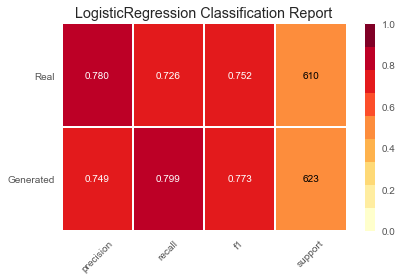

****Results****
Accuracy: 68.6216%
Recall: 68.6216%
Precision: 68.9773%
F1: 0.6857974107743312


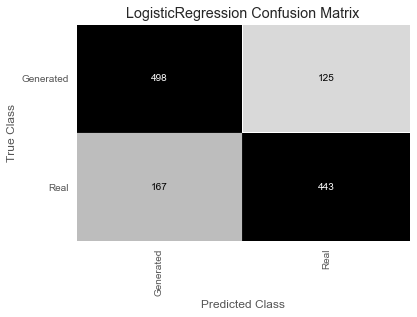

****Results****
Accuracy: 66.5135%
Recall: 66.5135%
Precision: 66.8436%
F1: 0.6643374753692546


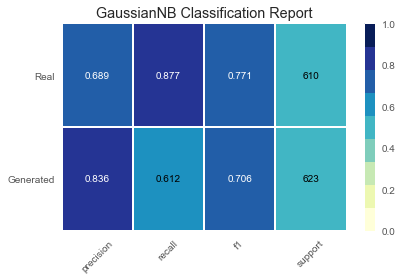

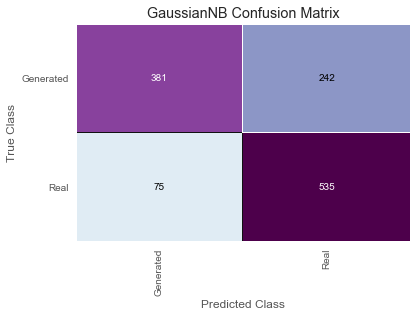

In [51]:
discrimant_classifier(X_train, X_test, y_train, y_test)#training classifier models

# Using glove Embeddings

In [52]:
word_indexed=[[all_char_num[word] for word in seq ]for seq in sequence ]#converting sequence from words to index
char_indexed = [all_char_num[word] for word in n_char]#converting next_character from words to index
y_=to_categorical(char_indexed) #converting chars to one hot vectors

In [53]:
#splitting into train/test and validation sets
train_X=word_indexed[:train_size]
train_y=y_[:train_size,:]

test_X=word_indexed[train_size+1:test_size+1]
test_y=y_[train_size+1:test_size+1,:]

dev_X=word_indexed[test_size+1:]
dev_y=y_[test_size+1:,:]

In [54]:
#creatin a matrix where rows are words and columns are dimensions of glove
number_words=len(all_words)
dim=200
init=np.zeros((number_words+1,dim))
for word, i in all_char_num.items():
    try:
        embedding_vector = glove[word]
        # words not found in embedding index will be all-zeros.
        init[i] = embedding_vector
    except:
        pass     

In [55]:
#initializing word_embedding vector
wv_layer = Embedding(number_words+1,
                     dim,
weights=[init],
                     input_length=25,
                     trainable=False)

In [56]:
#initializing LSTM model
seq_=Input(shape=(25,), dtype='int32', name='main_input')


embedded_sequences = wv_layer(seq_)

embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)

x=Bidirectional(LSTM(32,return_sequences=False))(embedded_sequences)

x=Dropout(0.3)(x)

x=Dense(len(all_words),activation='softmax')(x)

model_glove = Model(seq_, x)

In [57]:
#setting optimizer
optimizer = keras.optimizers.RMSprop(lr=0.01)
model_glove.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=["accuracy"])

## Don't Run This line below unless you want to wait several hours

In [42]:
#fiiting model
history_=model_glove.fit(train_X, train_y,
          batch_size=1000,
          epochs=40,callbacks=[es],validation_data=[dev_X[:5000],dev_y[:5000]])

Train on 210985 samples, validate on 5000 samples
Epoch 1/40
210985/210985 [==============================] - 349s 2ms/step - loss: 5.7452 - acc: 0.1181 - val_loss: 5.3482 - val_acc: 0.1500
Epoch 2/40
210985/210985 [==============================] - 345s 2ms/step - loss: 5.3997 - acc: 0.1378 - val_loss: 5.2160 - val_acc: 0.1626
Epoch 3/40
210985/210985 [==============================] - 370s 2ms/step - loss: 5.3101 - acc: 0.1416 - val_loss: 5.1622 - val_acc: 0.1660
Epoch 4/40
210985/210985 [==============================] - 360s 2ms/step - loss: 5.2598 - acc: 0.1447 - val_loss: 5.1486 - val_acc: 0.1662
Epoch 5/40
210985/210985 [==============================] - 662s 3ms/step - loss: 5.2316 - acc: 0.1471 - val_loss: 5.1196 - val_acc: 0.1646
Epoch 6/40
210985/210985 [==============================] - 340s 2ms/step - loss: 5.2139 - acc: 0.1483 - val_loss: 5.1064 - val_acc: 0.1674
Epoch 7/40
210985/210985 [==============================] - 349s 2ms/step - loss: 5.2001 - acc: 0.1492 - val_l

# Only Run this if you ran line above

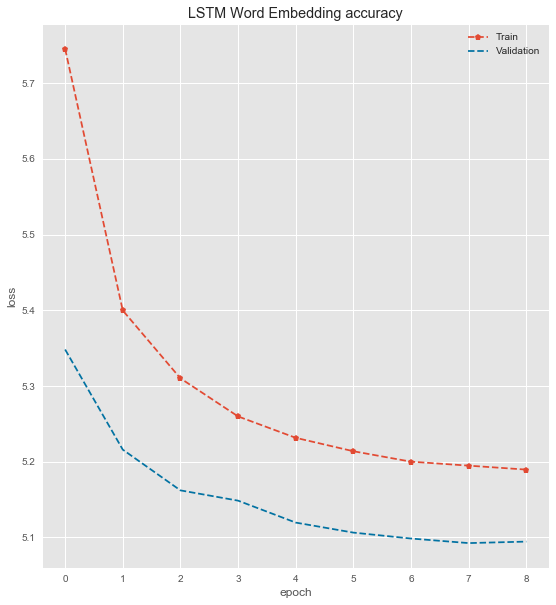

In [99]:
#plotting validation loss
plt.figure(figsize = (20,10))
plt.subplot(1, 2, 1)
plt.plot(history_.history['loss'],"p--")
plt.plot(history_.history['val_loss'],"b--")
plt.title('LSTM Word Embedding accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='best')

In [43]:
model_glove.save_weights("word_embedding.h5")#save weights

# Run this instead

In [58]:
model_glove = load_model("word_embedding_model.h5") #load model

In [44]:
model_glove.save("word_embedding_model.h5") #save model

## Discriminant Classifier

In [59]:
X_train, X_test, y_train, y_test = discriminant_data(model_glove,dev_X,test_X) #get discriminant data

[': they who with doll as like knows what bridge chose he smiles always jon the and idiot an id never you away we could', 'may matter me and of and hes no standing dothraki name way you he want to no you was to : the should do trust', 'be you need bronn grace you fighting to back a then large how grey to in won bronn to sandor what jaime it : we', 'and ive well its turned made what on know bran could the hell and ask to you me lord but was bronn three we :', 'you i you my of : i a the well the hello to me only through person in where gods castles even any we walder']


/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


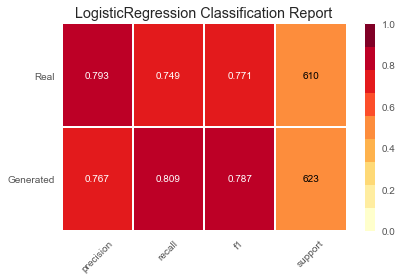

****Results****
Accuracy: 72.8108%
Recall: 72.8108%
Precision: 73.1636%
F1: 0.7277887190591501


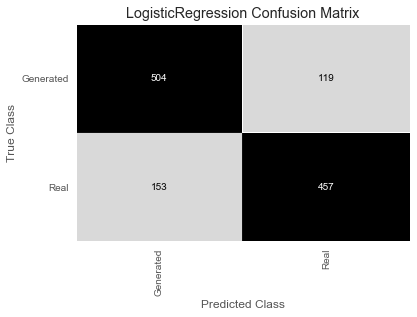

****Results****
Accuracy: 68.1081%
Recall: 68.1081%
Precision: 68.3355%
F1: 0.6802043479944893


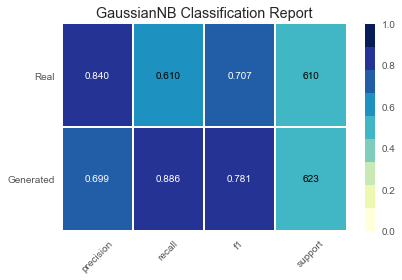

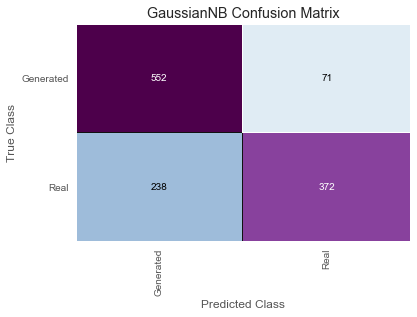

In [60]:
discrimant_classifier(X_train, X_test, y_train, y_test)